In [1]:
import numpy as np
from typing import Tuple
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.utils import plot_model

2023-06-13 08:57:32.264731: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-13 08:57:32.300010: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 08:57:32.506224: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 08:57:32.507456: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 08:57:34.442316: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Load the data and label
def load_data(filename: str) -> Tuple[np.ndarray, np.ndarray]:
    data = np.load(f'{filename}')
    return data['data'], data['labels']
# Split the data and labels into training and testing sets
train_data, train_labels = load_data('train_data_SYN.npz')
print(train_data.shape)
print(np.unique(train_labels, return_counts=True))
test_data, test_labels = load_data('test_data_SYN.npz')
print(test_data.shape)
print(np.unique(test_labels, return_counts=True))
x_train = train_data
y_train = train_labels
x_test = test_data
y_test = test_labels

(5000, 1024)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([563, 633, 529, 482, 486, 456, 504, 486, 442, 419]))
(5000, 1024)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([483, 539, 539, 484, 490, 526, 483, 506, 471, 479]))


In [3]:
# input: # of features, x_train with n features, x_test with n features
# return: hidden layer weights, prints accuracy
def train_model(n: int, x_train: np.ndarray, x_test: np.ndarray) -> np.ndarray:
    input_tensor = tf.keras.Input(shape=(n,))
    hidden_size = 132
    reg_l1_param = 0.001
    hidden_layer_1 = tf.keras.layers.Dense(units=hidden_size, activation=tf.nn.relu, 
                                           name = 'hidden_layer',
                                           activity_regularizer=tf.keras.regularizers.l1(reg_l1_param))(input_tensor)
    output_layer = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax, name = 'classification_layer')(hidden_layer_1)
    model = tf.keras.Model(inputs=input_tensor, outputs=output_layer)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=10, batch_size=32, 
                        validation_data=(x_test, y_test))
    test_loss, test_acc = model.evaluate(x_test, y_test)
    summary = model.summary()
    hidden_w = model.layers[1].get_weights()[0]

    print(f"accuracy with {n} features is: {test_acc}")
    return hidden_w

In [4]:
# input: hidden layer weights
# return: index of 10 features with highest weight
def feature_selection(feature_w: np.ndarray) -> np.ndarray:
    f = np.abs(feature_w)
    sum_w = np.array([])
    count = f.shape[0]
    for i in range(count):
        sum = np.sum(f[i])
        sum_w = np.append(sum_w, sum)
    index = np.argpartition(sum_w, -10)[-10:]
    return index

In [5]:
# input: x_train, x_test
# return: accuracy
def train_svm(x_train: np.ndarray, x_test: np.ndarray) -> float:
    svc = SVC(kernel='rbf', C=10)
    svc.fit(x_train, y_train)
    y_pred = svc.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [6]:
n = 1024
x_train_new = x_train
x_test_new = x_test
x_train_best = x_train
x_test_best = x_test
best_ind = np.array([0])
score = np.array([])

In [14]:
for i in range(10, 15):
    hidden_w = train_model(n, x_train_new, x_test_new)
    index = feature_selection(hidden_w)
    best_ind = np.append(best_ind, index)
    if(i==0): best_ind = np.delete(best_ind, 0)
    
    x_train_best = x_train[:][:, best_ind]
    x_test_best = x_test[:][:, best_ind] # could be random
    
    # train svm with x_train_best
    accuracy = train_svm(x_train_best, x_test_best)
    penalty = 0.00075 * (i+1) * 10
    sc = accuracy - penalty
    score = np.append(score, sc)
    
    x_train_new = np.delete(x_train_new, index, axis = 1)
    x_test_new = np.delete(x_test_new, index, axis = 1)
    n -= 10;
    
    print(f"##### {(i+1)*10} features: accuracy = {accuracy}, score = {sc} #####")

Epoch 1/10
157/157 [==============================] - 2s 9ms/step - loss: 0.8121 - accuracy: 0.7666 - val_loss: 0.5909 - val_accuracy: 0.8404
Epoch 2/10
157/157 [==============================] - 1s 8ms/step - loss: 0.3713 - accuracy: 0.9210 - val_loss: 0.5200 - val_accuracy: 0.8594
Epoch 3/10
157/157 [==============================] - 1s 7ms/step - loss: 0.2552 - accuracy: 0.9584 - val_loss: 0.4795 - val_accuracy: 0.8684
Epoch 4/10
157/157 [==============================] - 1s 7ms/step - loss: 0.1866 - accuracy: 0.9788 - val_loss: 0.4604 - val_accuracy: 0.8746
Epoch 5/10
157/157 [==============================] - 1s 8ms/step - loss: 0.1409 - accuracy: 0.9912 - val_loss: 0.4542 - val_accuracy: 0.8782
Epoch 6/10
157/157 [==============================] - 1s 7ms/step - loss: 0.1103 - accuracy: 0.9978 - val_loss: 0.4524 - val_accuracy: 0.8780
Epoch 7/10
157/157 [==============================] - 1s 8ms/step - loss: 0.0915 - accuracy: 0.9998 - val_loss: 0.4479 - val_accuracy: 0.8798
Epoch 

Epoch 6/10
157/157 [==============================] - 1s 7ms/step - loss: 0.1075 - accuracy: 0.9982 - val_loss: 0.4613 - val_accuracy: 0.8766
Epoch 7/10
157/157 [==============================] - 1s 7ms/step - loss: 0.0898 - accuracy: 0.9994 - val_loss: 0.4453 - val_accuracy: 0.8804
Epoch 8/10
157/157 [==============================] - 1s 7ms/step - loss: 0.0785 - accuracy: 1.0000 - val_loss: 0.4395 - val_accuracy: 0.8836
Epoch 9/10
157/157 [==============================] - 1s 7ms/step - loss: 0.0700 - accuracy: 1.0000 - val_loss: 0.4373 - val_accuracy: 0.8860
Epoch 10/10
157/157 [==============================] - 1s 3ms/step - loss: 0.4309 - accuracy: 0.8844
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 894)]             0         
                                                                 
 hidden_layer (Dense)        (None, 132)         

In [15]:
print(best_ind.shape)
print(score)

(150,)
[0.3689 0.4316 0.4935 0.5742 0.6355 0.6456 0.6641 0.6664 0.6891 0.6952
 0.7043 0.6992 0.6973 0.6972 0.6967]


In [22]:
acc = np.array([])
for i in range(15):
    pen = 0.0075 * (i+1)
    a = score[i] + pen
    acc = np.append(acc, a)
print(acc)

[0.3764 0.4466 0.516  0.6042 0.673  0.6906 0.7166 0.7264 0.7566 0.7702
 0.7868 0.7892 0.7948 0.8022 0.8092]


In [18]:
i = np.argpartition(score, -1)[-1:]
high_score = score[i]
print(high_score)
print(i+1)
# highest score is 0.7043
# i is 11 -> first top 110 features

[0.7043]
[11]


accuracy = 0.7868


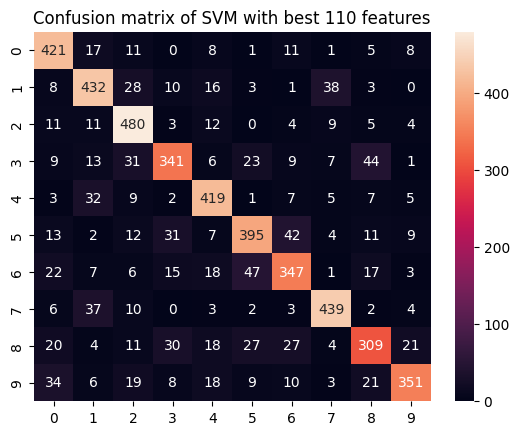

In [19]:
result_ind = best_ind[0:110]
best_features = x_train[:][:, result_ind]
y = x_test[:][:, result_ind]

svc = SVC(kernel='rbf', C=10)
svc.fit(best_features, y_train)
y_pred = svc.predict(y)
accuracy = accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion matrix of SVM with best 110 features')
print(f"accuracy = {accuracy}")